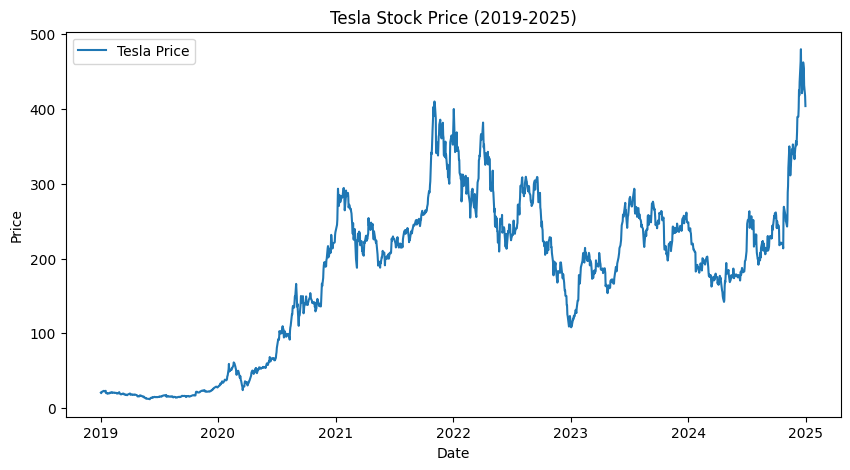

In [ ]:
# Importing libraries
import yfinance as yf
import matplotlib.pyplot as plt

ticker_symbol = "TSLA"
ticker = yf.Ticker(ticker_symbol)

# Downloading financial data
historical_data = ticker.history(start="2019-01-01", end="2025-01-01")

# 4. Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(historical_data['Close'], label='Tesla Price')
plt.title("Tesla Stock Price (2019-2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler


# Converting the 'Close' prices as a 2D numpy array (RESHAPING)
raw_prices = np.log1p(historical_data['Close'].values.reshape(-1, 1))

# Squash prices between 0 and 1 (NORMALIZATION)
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_scaled_log = scaler.fit_transform(raw_prices)

# Creating Sequences (The Sliding Window)
def create_sequences(data, seq_length):
    xs = []
    ys = []
    # Loop through the data to create "windows."
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60  # We will use the history of 60 days to predict the next one
X, y = create_sequences(prices_scaled_log, SEQ_LENGTH)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

print(f"Original shape: {prices_scaled_log.shape}")
print(f"New X shape: {X_tensor.shape}")
print(f"New y shape: {y_tensor.shape}")

Original shape: (1510, 1)
New X shape: torch.Size([1450, 60, 1])
New y shape: torch.Size([1450, 1])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Defining model parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

# Defining hyperparameters
lr = 0.01
num_epochs = 100

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_size = int(len(X) * 0.8)

# Converting to PyTorch Tensors
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

trainX = X_tensor[:train_size]
trainY = y_tensor[:train_size]
testX = X_tensor[train_size:]
testY = y_tensor[train_size:]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True means input shape is (batch, seq, feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # Take the last time step output for prediction
        out = self.fc(out[:, -1, :])
        return out, hn, cn

model = LSTMModel(input_size,hidden_size, num_layers, output_size)

# Define the Loss Function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
lstm_pred_y = []

# Training Loop
import time #To keep a track of the training time so that it can be compared later
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    #Forward Pass
    outputs, hn, cn = model.forward(trainX)
    lstm_pred_y.append(outputs)
    print(lstm_pred_y)
    hn, cn = hn.detach(), cn.detach()  # Detach hidden states if you are doing Truncated BPTT
    #Computing loss
    loss = criterion(outputs, trainY)
    print("Epoch ", epoch+1 , "MSE: ", loss.item())
    #Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Streaming output truncated to the last 5000 lines.
        [ 0.5325],
        [ 0.5369]], grad_fn=<AddmmBackward0>), tensor([[-0.7824],
        [-0.7802],
        [-0.7766],
        ...,
        [ 0.5446],
        [ 0.5419],
        [ 0.5464]], grad_fn=<AddmmBackward0>), tensor([[-0.8198],
        [-0.8175],
        [-0.8138],
        ...,
        [ 0.5570],
        [ 0.5542],
        [ 0.5588]], grad_fn=<AddmmBackward0>), tensor([[-0.8399],
        [-0.8375],
        [-0.8337],
        ...,
        [ 0.5639],
        [ 0.5611],
        [ 0.5657]], grad_fn=<AddmmBackward0>), tensor([[-0.8365],
        [-0.8341],
        [-0.8301],
        ...,
        [ 0.5606],
        [ 0.5579],
        [ 0.5628]], grad_fn=<AddmmBackward0>), tensor([[-0.8133],
        [-0.8107],
        [-0.8065],
        ...,
        [ 0.5501],
        [ 0.5476],
        [ 0.5528]], grad_fn=<AddmmBackward0>), tensor([[-0.7809],
        [-0.7782],
        [-0.7738],
        ...,
        [ 0.5396],
        [ 0.5374],


In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
model = GRU(input_dim=input_size, hidden_dim=hidden_size, output_dim=output_size, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
gru_pred_y=[]
for t in range(num_epochs):
    y_train_pred = model(trainX)
    gru_pred_y.append(y_train_pred)
    print(y_train_pred)
    loss = criterion(y_train_pred, trainY)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

tensor([[0.2026],
        [0.2025],
        [0.2023],
        ...,
        [0.1833],
        [0.1833],
        [0.1832]], grad_fn=<AddmmBackward0>)
Epoch  0 MSE:  0.33074289560317993
tensor([[0.0992],
        [0.1003],
        [0.1021],
        ...,
        [0.5204],
        [0.5191],
        [0.5201]], grad_fn=<AddmmBackward0>)
Epoch  1 MSE:  0.17830206453800201
tensor([[-0.5775],
        [-0.5758],
        [-0.5726],
        ...,
        [ 0.3607],
        [ 0.3571],
        [ 0.3582]], grad_fn=<AddmmBackward0>)
Epoch  2 MSE:  0.0383182056248188
tensor([[-1.3699],
        [-1.3684],
        [-1.3647],
        ...,
        [ 0.8947],
        [ 0.8839],
        [ 0.8812]], grad_fn=<AddmmBackward0>)
Epoch  3 MSE:  0.173576220870018
tensor([[-1.0001],
        [-0.9974],
        [-0.9927],
        ...,
        [ 0.3385],
        [ 0.3338],
        [ 0.3364]], grad_fn=<AddmmBackward0>)
Epoch  4 MSE:  0.04766601696610451
tensor([[-0.5940],
        [-0.5910],
        [-0.5862],
        ...,


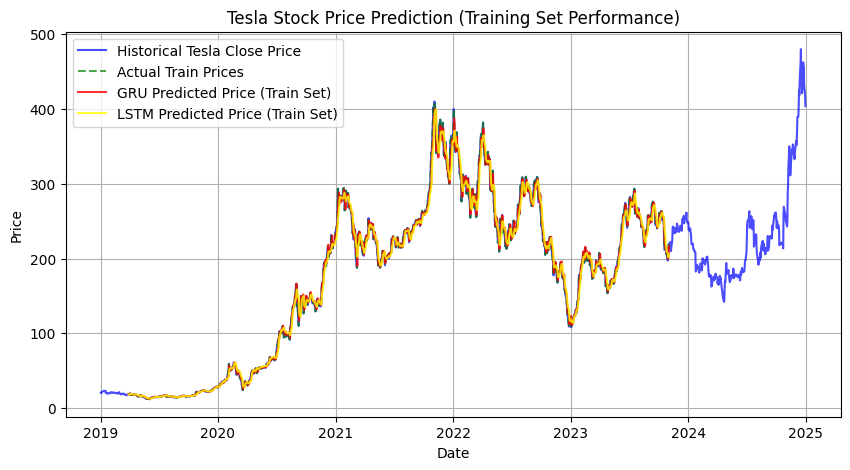

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


final_gru_predictions_scaled = gru_pred_y[-1].detach().cpu().numpy()
final_lstm_predictions_scaled = lstm_pred_y[-1].detach().cpu().numpy()


gru_predictions_original_scale = np.expm1(scaler.inverse_transform(final_gru_predictions_scaled))
lstm_predictions_original_scale = np.expm1(scaler.inverse_transform(final_lstm_predictions_scaled))

prediction_dates_for_train_set = historical_data.index[SEQ_LENGTH : SEQ_LENGTH + train_size]

# 4. Create new DataFrames for plotting with the correct date index
gru_pred_df_for_plot = pd.DataFrame(
    gru_predictions_original_scale,
    index=prediction_dates_for_train_set,
    columns=['GRU Predicted Price']
)
lstm_pred_df_for_plot = pd.DataFrame(
    lstm_predictions_original_scale,
    index=prediction_dates_for_train_set,
    columns=['LSTM Predicted Price']
)

actual_train_y_original_scale = np.expm1(scaler.inverse_transform(trainY.cpu().numpy()))
actual_train_y_df_for_plot = pd.DataFrame(
    actual_train_y_original_scale,
    index=prediction_dates_for_train_set,
    columns=['Actual Train Price']
)

# 5. Plot the data
plt.figure(figsize=(10, 5))

# Plot original historical data
plt.plot(historical_data['Close'], label='Historical Tesla Close Price', color='blue', alpha=0.7)

# Plot actual training prices (for direct comparison with predictions)
plt.plot(actual_train_y_df_for_plot, label='Actual Train Prices', color='green', linestyle='--', alpha=0.7)

# Plot GRU predictions
plt.plot(gru_pred_df_for_plot, label='GRU Predicted Price (Train Set)', color='red', alpha=0.8)

# Plot LSTM predictions
plt.plot(lstm_pred_df_for_plot, label='LSTM Predicted Price (Train Set)', color='yellow', alpha=0.8)

plt.title("Tesla Stock Price Prediction (Training Set Performance)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()